# Baseline  


In [1]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss,mean_absolute_error
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 한글 깨짐
import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        #!wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        #!mv malgun.ttf /usr/share/fonts/truetype/
        #import matplotlib.font_manager as fm 
        #fm._rebuild() 
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [3]:
train_raw = pd.read_csv('train.csv',encoding = 'utf-8')
test_raw = pd.read_csv('test.csv',encoding = 'utf-8')
train = train_raw
test = test_raw

In [6]:
#메뉴는 일단 제외
#drops = ['조식메뉴', '중식메뉴', '석식메뉴']

#train = train.drop(drops, axis=1)
#test = test.drop(drops, axis=1)

In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
 12  Is_new          1205 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 122.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  -

In [8]:
#train.describe
print(train.isnull().sum())
print(test.isnull().sum())

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
중식계               0
석식계               0
Is_new            0
dtype: int64
일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
Is_new            0
dtype: int64


In [4]:
#날짜 전처리;
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['year'] = train['일자'].dt.year
train['month'] = train['일자'].dt.month
train['week'] = train['일자'].dt.week
train['day'] = train['일자'].dt.day

test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['week'] = test['일자'].dt.week
test['day'] = test['일자'].dt.day

In [7]:
#holiday join
holiday['요일'] = holiday['요일'].str[0]
holiday.rename(columns ={
    '명칭':'명칭','날짜':'일자','요일':'요일'},inplace = True)
holiday.head(20)

,명칭,일자,요일
0,신정,20160101,금
1,설날,20160207,일
2,설날,20160208,월
3,설날,20160209,화
4,대체공휴일,20160210,수
5,삼일절,20160301,화
6,국회의원선거일,20160413,수
7,어린이날,20160505,목
8,석가탄신일,20160514,토
9,현충일,20160606,월


In [16]:
#pd.to_datetime input 인자 str
holiday['일자'] = pd.to_datetime(holiday['일자'].astype('str'))
#holiday.head()
#holiday.info()

In [20]:
train.일자.head(30)

0    2016-02-01
1    2016-02-02
2    2016-02-03
3    2016-02-04
4    2016-02-05
5    2016-02-11
6    2016-02-12
7    2016-02-15
8    2016-02-16
9    2016-02-17
10   2016-02-18
11   2016-02-19
12   2016-02-22
13   2016-02-23
14   2016-02-24
15   2016-02-25
16   2016-02-26
17   2016-02-29
18   2016-03-02
19   2016-03-03
20   2016-03-04
21   2016-03-07
22   2016-03-08
23   2016-03-09
24   2016-03-10
25   2016-03-11
26   2016-03-14
27   2016-03-15
28   2016-03-16
29   2016-03-17
Name: 일자, dtype: datetime64[ns]

In [17]:
holiday_list = holiday['일자']
af_holiday = holiday_list.map(lambda x:x+dt.timedelta(days=1))
bf_holiday = holiday_list.map(lambda x:x-dt.timedelta(days=1))  
ab_holiday = [af_holiday,bf_holiday]
ab_holiday

[0     2016-01-02
 1     2016-02-08
 2     2016-02-09
 3     2016-02-10
 4     2016-02-11
 5     2016-03-02
 6     2016-04-14
 7     2016-05-06
 8     2016-05-15
 9     2016-06-07
 10    2016-08-16
 11    2016-09-15
 12    2016-09-16
 13    2016-09-17
 14    2016-10-04
 15    2016-10-10
 16    2016-12-26
 17    2017-01-02
 18    2017-01-28
 19    2017-01-29
 20    2017-01-30
 21    2017-01-31
 22    2017-03-02
 23    2017-05-04
 24    2017-05-06
 25    2017-05-10
 26    2017-06-07
 27    2017-08-16
 28    2017-10-03
 29    2017-10-04
 30    2017-10-04
 31    2017-10-05
 32    2017-10-06
 33    2017-10-07
 34    2017-10-10
 35    2017-12-26
 36    2018-01-02
 37    2018-02-16
 38    2018-02-17
 39    2018-02-18
 40    2018-03-02
 41    2018-05-06
 42    2018-05-08
 43    2018-05-23
 44    2018-06-07
 45    2018-06-14
 46    2018-08-16
 47    2018-09-24
 48    2018-09-25
 49    2018-09-26
 50    2018-09-27
 51    2018-10-04
 52    2018-10-10
 53    2018-12-26
 54    2019-01-02
 55    201

In [24]:
#왜 겹치는 날 있는데 1안나오니?
for i in range(0,len(train)-1):
    if train['일자'][i] in [af_holiday.item]:
        print(1)

In [29]:
train['일자'][0]
af_holiday[1]

Timestamp('2016-02-08 00:00:00')

In [25]:
a = train['일자'].apply(lambda x: 1 if x in [af_holiday.item,bf_holiday.item] else 0)
a.sum()

0

# Holiday 전후 1일 레이블링하여 left join from R

In [5]:
#R에서 전처리해서 Is_holiday 가져오기
Is_holiday = pd.read_csv('Is_holiday.csv',encoding = 'utf-8')
Is_holiday.Is_holiday.sum()
#78개의 1인 행 존재
#Is_holiday.info()

80

In [6]:
Is_holiday['일자'] = pd.to_datetime(Is_holiday['일자'])

In [7]:
#left join on '일자'
train = pd.merge(train,Is_holiday, left_on='일자', right_on='일자', how='left')
test = pd.merge(test,Is_holiday,left_on = '일자', right_on='일자', how ='left')

# holiday 전후 2일

In [8]:
#R에서 전처리해서 Is_holiday 가져오기
Is_holiday2 = pd.read_csv('Is_holiday2.csv',encoding = 'utf-8')
Is_holiday2.rename(columns ={
    '일자':'일자','Is_holiday':'Is_holiday2'},inplace =True)
Is_holiday2.Is_holiday2.sum()
#159개의 1인 행 존재
Is_holiday2.sum()

일자             2016-02-012016-02-022016-02-032016-02-042016-0...
Is_holiday2                                                  159
dtype: object

In [9]:
Is_holiday2['일자'] = pd.to_datetime(Is_holiday2['일자'])

In [10]:
#left join on '일자'
train = pd.merge(train,Is_holiday2, left_on='일자', right_on='일자', how='left')
test = pd.merge(test,Is_holiday2,left_on = '일자', right_on='일자', how ='left')

In [11]:
#요일 라벨 인코딩
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

#내부근무자수 생성
train['내부근무자수'] = train['본사정원수']-train['본사휴가자수']-train['본사출장자수']-train['현본사소속재택근무자수']
test['내부근무자수'] = test['본사정원수']-test['본사휴가자수']-test['본사출장자수']-test['현본사소속재택근무자수']
#식수가능인원!=내부근무자수 : 본사출장자수는 중식먹고 오후에 출장을 갈 수 있다는 가정. 이후 확인 필요함
#train['식수가능인원'] = train['본사정원수']-train['본사휴가자수']-train['현본사소속재택근무자수']
#test['식수가능인원'] = test['본사정원수']-test['본사휴가자수']-test['현본사소속재택근무자수']

In [12]:
#석식계 요일 rank_labeling
weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
dtypes: d

<AxesSubplot:>

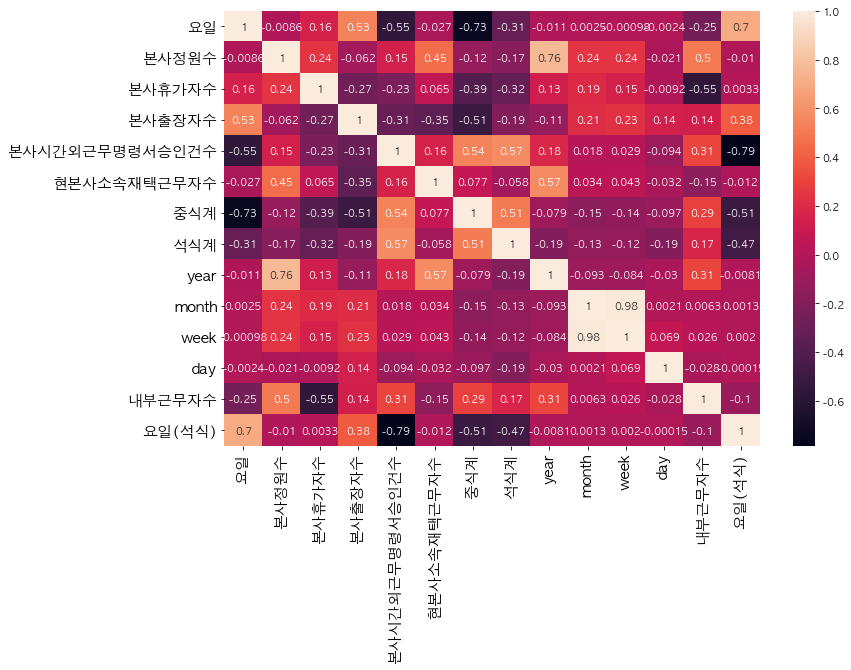

In [19]:
#상관관계 분석
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.corr(), annot = True)
#중식계와 유의미한 변수 : 요일, 본사시간외근무명령서승인건수(야근),본사출장자수/석식계 ,본사휴가자수 
#석식계와 유의미한 변수 : 본사시간외근무명령서승인건수, 중식계, 본사휴가자수 

<AxesSubplot:>

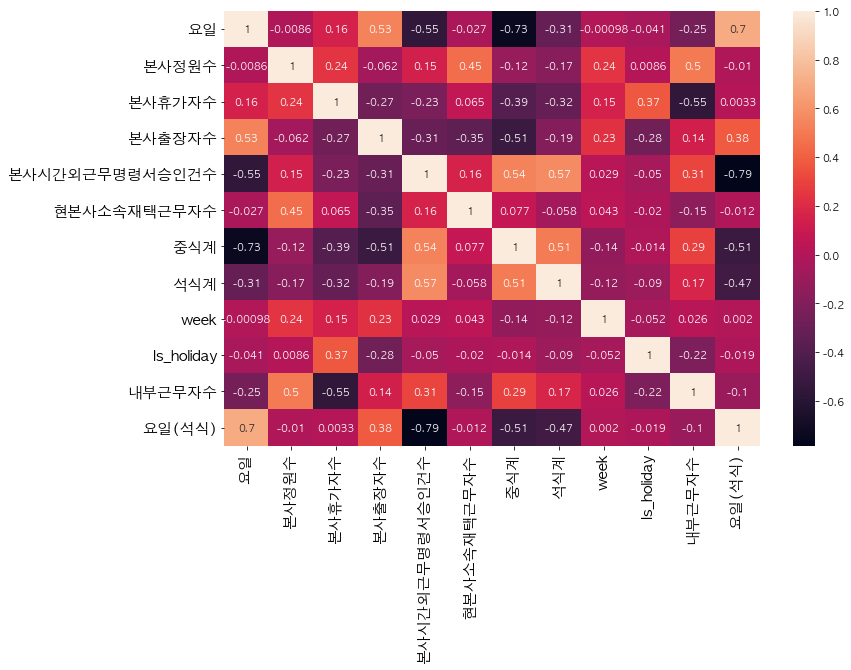

In [26]:
#요일 제외 유의미하지 않으니 year,month,day제외하고 heatmap
plt.figure(figsize = (12,8))
plt.xticks(color = "black", fontsize = 15)
plt.yticks(color = "black", fontsize = 15)
sns.heatmap(train.drop(['year','month','day'],axis = 1).corr(),annot = True)

- 시각화 결과 2020년 4월 이후 일정기간 중석식계 모두 감소가 있었다. 그 이유는 무엇일까?  
    가장 큰 예상 이유는 코로나이다. but, 코로나가 어떻게 본사에 영향을 주었는지는 추후에 판단이 필요하다
    - 예상1) 내부근무자수 감소(= 출장자 + 휴가자수 증가 or 재택근무자수 증가)
    - 예상2) 본사 정원수 감소

# 토픽모델링 적용 - baseline에 일단 적용 X후 제출 요망

In [14]:
train_tp = pd.read_csv('train_topic.csv',encoding = 'cp949')
test_tp = pd.read_csv('test_topic.csv',encoding = 'cp949')

In [15]:
train_tp = train_tp[['Topic1','Topic2','Topic3','Topic4','일자']]
test_tp = test_tp[['Topic1','Topic2','Topic3','Topic4','일자']]

In [16]:
train_tp['일자'] = pd.to_datetime(train_tp['일자'])
test_tp['일자'] = pd.to_datetime(test_tp['일자'])

In [17]:
train =pd.merge(train,train_tp, left_on='일자', right_on='일자', how='left')
test = pd.merge(test,test_tp,left_on = '일자', right_on='일자', how ='left')

In [18]:
#Topic 변수 na값은 0으로 대체
train = train.fillna(0)
test = test.fillna(0)

In [232]:
#Clust 변수 factor화
#train['clust'] = train['clust'].astype(str)
#test['clust'] = test['clust'].astype(str)

#>Facotr화하면 모델에 적용이 안됌. why?

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  Is_holiday      1205 non-null   int64         
 14  내부근무자수          1205 non-null   float64       
 15  요일(석

In [30]:
#변수들의 실제 비율을 알고자 변수 생성
train['휴가비율'] = train.본사휴가자수 / train.본사정원수
train['출장비율'] = train.본사출장자수 / train.본사정원수
train['야근비율'] = train.본사시간외근무명령서승인건수 / train.본사정원수
train['재택근무비율'] = train.현본사소속재택근무자수 / train.본사정원수

test['휴가비율'] = test.본사휴가자수 / test.본사정원수
test['출장비율'] = test.본사출장자수 / test.본사정원수
test['야근비율'] = test.본사시간외근무명령서승인건수 / test.본사정원수
test['재택근무비율'] = test.현본사소속재택근무자수 / test.본사정원수

In [235]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식계             1205 non-null   float64       
 8   석식계             1205 non-null   float64       
 9   year            1205 non-null   int64         
 10  month           1205 non-null   int64         
 11  week            1205 non-null   int64         
 12  day             1205 non-null   int64         
 13  내부근무자수          1205 non-null   float64       
 14  요일(석식)          1205 non-null   int64         
 15  emp_

In [12]:
#일자,yr_mt drop
#train.drop(['일자'],axis = 1,inplace = True)
#test.drop(['일자'],axis = 1,inplace = True)
#Data select에서 선택안하면 됌.

# 월별 평균  
요일별 평균 중석식계 구해서 df에 매핑하기

In [19]:
dow_mean = train.groupby(['month'])['중식계','석식계'].agg('mean').reset_index().round()
dow_mean.rename(columns = {'중식계':'중식계월평균',
                '석식계':'석식계월평균'},inplace = True)
train = pd.merge(train,dow_mean, left_on='month', right_on='month', how='left')
test = pd.merge(test,dow_mean,left_on = 'month', right_on='month', how ='left')

In [14]:
train.head(5)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,year,month,week,day,Is_holiday,Is_holiday2,내부근무자수,요일(석식),중식계월평균,석식계월평균
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,5,1,0,0,2401.0,1,990.0,515.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016,2,5,2,0,0,2378.0,2,990.0,515.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2016,2,5,3,0,0,2365.0,5,990.0,515.0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2016,2,5,4,0,0,2277.0,3,990.0,515.0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2016,2,5,5,0,1,2142.0,4,990.0,515.0


In [15]:
from sklearn.linear_model import LinearRegression
from scipy import stats
lm = LinearRegression()

In [60]:
X = train[['fr_rus']]
Y = train['중식계']

In [61]:
stats.pearsonr(train.fr_rus,train.중식계)

(-0.04469064037178044, 0.12101777480008054)

In [62]:
print(lm.fit(X,Y))
Yhat=lm.predict(X) #We can output a predictio
print(Yhat[0:5])
print('intercept value:', lm.intercept_)
print('coef value:', lm.coef_)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[891.48694187 891.48694187 891.48694187 891.48694187 891.48694187]
intercept value: 891.4869418702611
coef value: [-77.15360854]


# 메뉴 전처리

### new 메뉴 check

In [20]:
def menu_new(x):
    c = str(x).split(' ')
    c1 = re.findall("New",str(c))
    if 'New' in c1:
        return 1
    else:
        return 0

In [21]:
train['Is_new'] = train['중식메뉴'].apply(lambda x:menu_new(x))
test['Is_new'] = test['중식메뉴'].apply(lambda x:menu_new(x))
train['Is_new'].sum()
test['Is_new'].sum()

3

## 원산지

In [22]:
#원산지 마킹
#호주산
def origin_aust(x):
    b = str(x).split(' ')
    b1 = re.findall("호주산",str(b))
    if '호주산' in b1:
        return 1
    else:
        return 0

In [23]:
train["fr_aust"] = train['중식메뉴'].apply(lambda x:origin_aust(x))
test["fr_aust"] = test['중식메뉴'].apply(lambda x:origin_aust(x))
train['fr_aust'].sum()
test['fr_aust'].sum()

0

In [63]:
X = train[['fr_aust']]
Y = train['중식계']
stats.pearsonr(train.fr_aust,train.중식계)

(0.07096988641283626, 0.01373438949090561)

In [64]:
print(lm.fit(X,Y))
Yhat=lm.predict(X) #We can output a predictio
print(Yhat[0:5])
print('intercept value:', lm.intercept_)
print('coef value:', lm.coef_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[949.29166667 886.58781995 886.58781995 886.58781995 886.58781995]
intercept value: 886.5878199470433
coef value: [62.70384672]


In [24]:
#원산지 마킹
#러시아산
def origin_rus(x):
    b = str(x).split(' ')
    b1 = re.findall("러시아",str(b))
    if '러시아' in b1:
        return 1
    else:
        return 0

In [25]:
train["fr_rus"] = train['중식메뉴'].apply(lambda x:origin_rus(x))
test["fr_rus"] = test['중식메뉴'].apply(lambda x:origin_rus(x))
train['fr_rus'].sum()
test['fr_rus'].sum()

0

In [65]:
X = train[['fr_rus']]
Y = train['중식계']
stats.pearsonr(train.fr_rus,train.중식계)

(-0.04469064037178044, 0.12101777480008054)

In [66]:
print(lm.fit(X,Y))
Yhat=lm.predict(X) #We can output a predictio
print(Yhat[0:5])
print('intercept value:', lm.intercept_)
print('coef value:', lm.coef_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[891.48694187 891.48694187 891.48694187 891.48694187 891.48694187]
intercept value: 891.4869418702611
coef value: [-77.15360854]


In [26]:
#원산지 마킹
#중국산
def origin_cn(x):
    b = str(x).split(' ')
    b1 = re.findall("중국산",str(b))
    if '중국산' in b1:
        return 1
    else:
        return 0

In [27]:
train["fr_cn"] = train['중식메뉴'].apply(lambda x:origin_cn(x))
test["fr_cn"] = test['중식메뉴'].apply(lambda x:origin_cn(x))
train['fr_cn'].sum()
test['fr_cn'].sum()

0

# Modeling

In [82]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
 12  year            1205 non-null   int64         
 13  month           1205 non-null   int64         
 14  week            1205 non-null   int64         
 15  day 

In [71]:
train_lunch = train[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Is_holiday','Is_holiday2','중식계월평균','석식계월평균','Is_new',"fr_cn"]]
lunch_y = train['중식계']
test_lunch = test[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Is_holiday','Is_holiday2','중식계월평균','석식계월평균','Is_new',"fr_cn"]]

train_dinner = train[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Is_holiday','Is_holiday2','중식계월평균','석식계월평균','Is_new']]
dinner_y = train['석식계']
test_dinner = test[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Is_holiday','Is_holiday2','중식계월평균','석식계월평균','Is_new']]



In [72]:
from sklearn.ensemble import RandomForestRegressor
rf_lunch = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_dinner = RandomForestRegressor(n_jobs=-1, random_state=42)
#feature1 = X_test.columns.values

In [73]:
rf_lunch.fit(train_lunch, lunch_y)
rf_dinner.fit(train_dinner,dinner_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [74]:
pred_lunch = rf_lunch.predict(test_lunch)
pred_dinner = rf_dinner.predict(test_dinner)

# Importance plot

# 중식계 importance plot

In [75]:
importances = rf_lunch.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

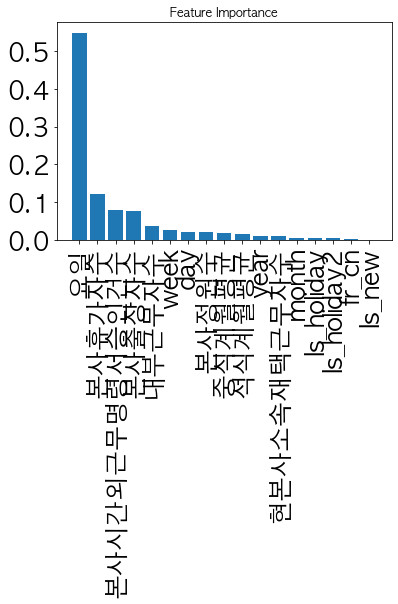

In [76]:
plt.title('Feature Importance')
plt.bar(range(train_lunch.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(train_lunch.shape[1]), train_lunch.columns[sorted_indices],rotation =90)
plt.xticks(color = "black", fontsize = 25)
plt.yticks(color = "black", fontsize = 25)
plt.tight_layout()
plt.show()

# 석식계 imporatance plot

In [25]:
importances = rf_dinner.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

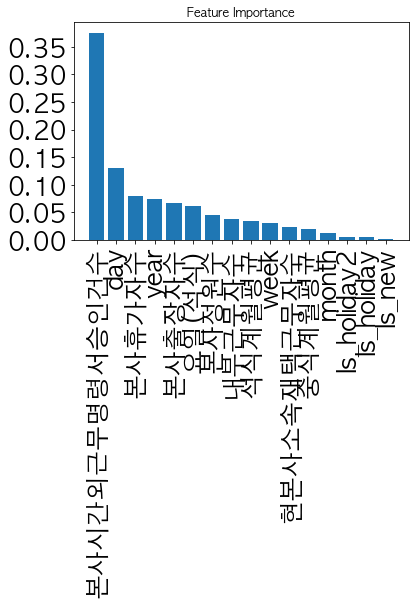

In [26]:
plt.title('Feature Importance')
plt.bar(range(train_dinner.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(train_dinner.shape[1]), train_dinner.columns[sorted_indices], rotation=90)
plt.xticks(color = "black", fontsize = 25)
plt.yticks(color = "black", fontsize = 25)
plt.tight_layout()
plt.show()

In [125]:
#submission = pd.read_csv('sample_submission.csv',encoding = 'utf-8')

In [126]:
#submission['중식계'] = pred1
#submission['석식계'] = pred2

In [127]:
#submission.to_csv('Topic02.csv', index=False)
#87

# Pycaret


In [150]:
train_lunch = train[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','중식계','year','Is_holiday',"Is_new",'중식계월평균','fr_rus']]
test_lunch = test[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year',"Is_holiday",'Is_new','중식계월평균','fr_rus']]

train_dinner = train[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','석식계','Is_holiday','Is_holiday2',"석식계월평균",'Topic1','fr_cn','Is_new']]
test_dinner = test[['요일(석식)','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수', '내부근무자수','본사출장자수', '본사휴가자수','day', 'week', 'month','year','Is_holiday','Is_holiday2','석식계월평균','Topic1','fr_cn','Is_new']]



In [94]:
#중식 모델
reg = setup(data=train_lunch,
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            fold =10,
            feature_selection = True,
            silent= True,
           session_id = 7163)

,Description,Value
0,session_id,7163
1,Target,중식계
2,Original Data,"(1205, 16)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 34)"


In [95]:
best_model = compare_models(n_select=2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,64.9477,7657.8813,87.2079,0.8247,0.1076,0.0787,0.7520
gbr,Gradient Boosting Regressor,68.5032,8464.6082,91.7007,0.8068,0.1138,0.0833,0.0750
xgboost,Extreme Gradient Boosting,72.3969,9267.5989,95.8471,0.7899,0.1176,0.0873,0.4360
ridge,Ridge Regression,72.3406,9288.2377,96.0727,0.7881,0.1188,0.0874,0.0160
lr,Linear Regression,72.4008,9295.0773,96.1166,0.7880,0.1183,0.0872,0.0110
br,Bayesian Ridge,72.4566,9309.4636,96.1690,0.7875,0.1194,0.0877,0.0210
lightgbm,Light Gradient Boosting Machine,72.2880,9308.4547,96.1582,0.7869,0.1198,0.0877,0.3310
huber,Huber Regressor,71.9015,9397.2798,96.6131,0.7858,0.1199,0.0867,0.0310
rf,Random Forest Regressor,71.1258,9424.1719,96.8255,0.7842,0.1206,0.0871,0.2420
lasso,Lasso Regression,73.4229,9542.7907,97.3817,0.7824,0.1214,0.0892,0.0120


In [96]:
blended_l = blend_models(estimator_list = best_model, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_lunch)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,60.6535,6568.8796,81.0486,0.8251,0.1008,0.0751
1,63.2101,7398.2362,86.0130,0.8445,0.1169,0.0811
2,65.4585,8279.8328,90.9936,0.8289,0.1046,0.0745
3,67.5954,8272.7019,90.9544,0.8218,0.1052,0.0791
4,70.6288,8376.8104,91.5249,0.8101,0.1158,0.0870
Mean,65.5093,7779.2922,88.1069,0.8261,0.1086,0.0794
SD,3.4476,701.6159,4.0578,0.0112,0.0065,0.0046


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,60.5415,6303.9534,79.3974,0.8470,0.0988,0.0746


1)cat 66 voting 60.64  
2)cat 66.32 votung 60.88 > 중석식요일평균-제거    
3)cat 65.97 voting 60.76 > 중식요일평균만-제거  
4)cat 65.24 voting 60.899> holiday추가  
5)cat 64.87 voting 61.40 > holiday2 - 제거    
6)cat 64.84 voting 60.79 > 중식월평균 추가  
7)cat 64.60 voting 60.14 > Is_new 추가  
8)cat 64.97 voting 60.54 > 호주산 추가  

9)cat 65.40 voting 60.54 > 러시아산 추가

In [72]:
cat_lunch = create_model('catboost', fold =10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,61.6041,6502.3040,80.6369,0.8299,0.0993,0.0763
1,62.2544,6671.5313,81.6794,0.8163,0.1063,0.0787
2,66.2505,8447.6341,91.9110,0.8233,0.1382,0.0932
3,62.5235,7490.5299,86.5478,0.8398,0.0949,0.0697
4,65.2429,7498.6750,86.5949,0.8424,0.1023,0.0752
5,61.8414,7598.3853,87.1687,0.8423,0.0984,0.0695
6,72.2676,9578.8597,97.8716,0.7872,0.1191,0.0885
7,60.1707,6218.3337,78.8564,0.8679,0.0826,0.0656
8,63.0464,6364.2323,79.7761,0.8760,0.1082,0.0787
9,74.2752,10208.3273,101.0363,0.7222,0.1263,0.0915


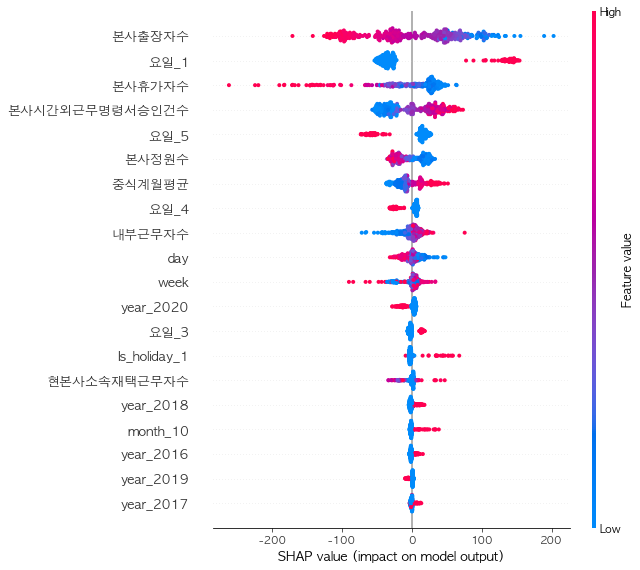

In [73]:
interpret_model(cat_lunch)

In [97]:
pred_esb_l = predict_model(final_model_l, test_lunch)

In [98]:
pred_esb_l['Label']

0      987.098471
1      921.420065
2      608.715410
3     1228.898041
4     1009.683961
5      970.718570
6      933.366466
7      676.418269
8     1262.578302
9     1034.244764
10     822.294551
11    1252.330617
12    1093.066890
13    1048.605583
14     894.054544
15     683.160520
16    1250.929967
17    1041.457835
18     939.553613
19     882.419841
20     632.652948
21    1172.119269
22    1003.628438
23     934.840435
24     703.020264
25    1282.644576
26    1101.892916
27    1018.960119
28     930.326788
29     713.722778
30    1269.831835
31    1031.550540
32    1036.624040
33     920.664615
34     676.347007
35    1229.247845
36     992.036539
37     926.077550
38     870.740071
39     622.454621
40    1206.404902
41     993.362285
42     951.583918
43     818.918694
44     643.509395
45    1211.420954
46     998.734383
47     962.689624
48     886.445452
49     646.191394
Name: Label, dtype: float64

In [99]:
submission = pd.read_csv('sample_submission.csv',encoding = 'utf-8')

In [100]:
submission['중식계'] = pred_esb_l['Label']
submission.head()

,일자,중식계,석식계
0,2021-01-27,987.098471,0
1,2021-01-28,921.420065,0
2,2021-01-29,608.715410,0
3,2021-02-01,1228.898041,0
4,2021-02-02,1009.683961,0


In [151]:
#석식계
reg = setup(data=train_dinner,
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            fold =10,
            feature_selection = True,
            silent= True,
           session_id = 7198)

,Description,Value
0,session_id,7198
1,Target,석식계
2,Original Data,"(1205, 18)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 37)"


In [152]:
best_model2 = compare_models(n_select = 2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,47.6133,4429.8598,65.0710,0.7725,0.5809,0.1106,0.3510
catboost,CatBoost Regressor,47.2466,4408.4350,65.1640,0.7723,0.7103,0.1086,0.7840
rf,Random Forest Regressor,48.3952,4716.9794,67.0433,0.7605,0.4578,0.1150,0.2320
gbr,Gradient Boosting Regressor,49.2521,4995.9359,69.3470,0.7405,0.6337,0.1146,0.0760
xgboost,Extreme Gradient Boosting,50.8109,5160.7949,70.3841,0.7328,0.6737,0.1150,0.4530
et,Extra Trees Regressor,50.2865,5248.7832,71.3653,0.7289,0.6150,0.1149,0.1860
ada,AdaBoost Regressor,61.4314,6744.2198,81.5199,0.6504,0.8290,0.1393,0.0570
dt,Decision Tree Regressor,64.7063,8705.3499,92.4153,0.5527,0.5135,0.1527,0.0140
knn,K Neighbors Regressor,66.0495,9365.9510,95.7434,0.5250,1.0567,0.1347,0.0150
lasso,Lasso Regression,67.0867,9371.6760,96.1391,0.5221,1.0763,0.1307,0.0110


In [153]:
blended_d = blend_models(estimator_list = best_model2, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,45.7276,3759.9080,61.3181,0.7958,0.6741,0.1110
1,42.2464,2981.4121,54.6023,0.8258,0.4965,0.1024
2,48.8594,4901.8888,70.0135,0.7532,0.7354,0.1173
3,54.9251,6287.9238,79.2964,0.7341,0.8003,0.1278
4,43.7197,3754.1703,61.2713,0.8077,0.7756,0.0879
Mean,47.0956,4337.0606,65.3003,0.7833,0.6964,0.1093
SD,4.4988,1152.0024,8.5398,0.0343,0.1087,0.0135


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,44.3947,3638.3381,60.3186,0.8033,0.6152,0.1089


1)cat 53.38 voting 50.62  
2)cat 53.94 voting 50.91 > 중식계요일평균만 추가  
3)cat 53.80 voting 50.51 > holiday변수 추가  
4)cat 53.44 voting 50.83 > holiday2변수 추가  
5)cat 53.66 voting 49.94 > 석식계 월평균 추가  
6)cat 53.93 voting 50.26 > new메뉴 추가 *성능이 떨어졌다.석식먹는 사람들은 어짜피 야근해서 먹는거기때문에 new여부 의미없을지도? 

7)44.3 > Topic1/나머지는 X. 

>현재의 변수들은 중식계 위주로 설명력이 높다, 그렇지만 석식계에 대한 변수들의 설명력이 낮으므로 이를 보완하는 파생변수 생성 필요  
>이후의 topicmodeling을 통해서 설명력을 높힐 수 있었다.  

In [131]:
cat_dinner = create_model('catboost', fold =10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,45.6715,4447.2290,66.6875,0.6652,0.1756,0.1208
1,48.5811,3796.6004,61.6166,0.8330,1.0804,0.1028
2,37.2801,2361.0278,48.5904,0.8290,0.2966,0.0874
3,47.1577,3571.9407,59.7657,0.8209,0.7215,0.1189
4,47.7039,5313.2347,72.8919,0.7182,0.9301,0.0969
5,51.8853,4974.2533,70.5284,0.7636,0.6213,0.1385
6,65.2739,9254.6199,96.2009,0.6240,0.9141,0.1524
7,42.5380,2817.8085,53.0830,0.8741,0.7440,0.0930
8,41.7750,2679.3192,51.7621,0.8728,0.7203,0.0909
9,47.1020,5204.9721,72.1455,0.7105,0.8562,0.0859


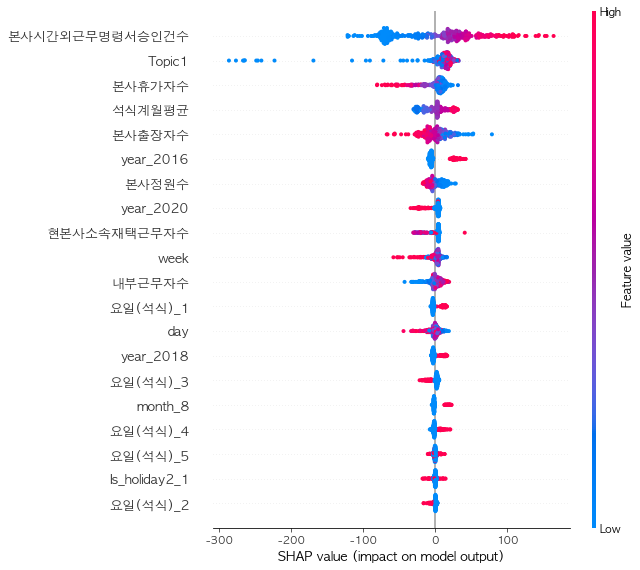

In [132]:
interpret_model(cat_dinner)

In [154]:
pred_esb_d = predict_model(final_model_d, test_dinner)

In [155]:
pred_esb_d['Label']

0     366.192403
1     396.670604
2     247.479618
3     567.663436
4     494.128499
5     453.125359
6     497.388539
7     390.831848
8     634.162752
9     543.776568
10    154.613803
11    685.151064
12    612.620845
13    445.363373
14    522.731359
15    373.388608
16    670.564416
17    621.552379
18    436.593692
19    524.842653
20    317.044977
21    674.971162
22    521.682906
23    577.061241
24    415.919874
25    644.516503
26    636.560965
27    472.371481
28    555.047425
29    360.480225
30    711.092754
31    590.773300
32    466.261326
33    508.089320
34    317.039052
35    659.424526
36    614.841665
37    422.126072
38    473.670191
39    301.127095
40    668.322563
41    612.193364
42    443.965108
43    443.972973
44    301.381483
45    620.299964
46    578.136281
47    429.712665
48    473.344331
49    301.675839
Name: Label, dtype: float64

In [156]:
submission['석식계'] = pred_esb_d['Label']

In [157]:
submission.to_csv('RRRBaseline+mtMean+New.csv', index=False)

# Autoviml

In [ ]:
from autoviml.Auto_ViML import Auto_ViML

In [255]:
target = '중식계'
m, feats, trainm, testm = Auto_ViML(train_lunch, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',
                            feature_reduction=True,
                             Boosting_Flag=True, Binning_Flag=False,
                            Add_Poly=False, Stacking_Flag=True,Imbalanced_Flag=False,
                            verbose=2)

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (1205, 13)
    Training Set Memory Usage = 0.12 MB
Test Set Shape = (50, 15)
    Test Set Memory Usage = 0.01 MB
Single_Label Target: ['중식계']
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 1205 rows, 12 cols
Data Set columns info:
* 요일: 0 nulls, 5 unique vals, most common: {4: 244, 1: 241}
* 휴가비율: 0 nulls, 1100 unique vals, most common: {0.026365348399246705: 3, 0.025423728813559324: 3}
* 출장비율: 0 nulls, 1113 unique vals, most common: {0.10621669626998224: 3, 0.09874723655121592: 3}
* 재택근무비율: 0 nulls, 193 unique vals, most common: {0.0: 988, 0.006779661016949152: 3}
* 내부근무자수: 0 nulls, 522 unique vals, most common: {2334.0: 9, 2330.0: 8}
* 본사출장자수: 0 nulls, 194 unique vals, m

TypeError: cannot unpack non-iterable NoneType object